# 1. Импорт библиотек

In [16]:
import time
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, random_split, Subset
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


# 1.1 Базовые директории

In [ ]:
base_dir = Path.home() / "cifar10_lab4"
base_dir.mkdir(parents=True, exist_ok=True)

data_root = base_dir / "data"
data_root.mkdir(parents=True, exist_ok=True)

logs_root = base_dir / "runs"
logs_root.mkdir(parents=True, exist_ok=True)

checkpoints_root = base_dir / "checkpoints"
checkpoints_root.mkdir(parents=True, exist_ok=True)

print("base_dir:", base_dir)
print("data_root:", data_root)
print("logs_root:", logs_root)
print("checkpoints_root:", checkpoints_root)

base_dir: /Users/vladimir/cifar10_lab4
data_root: /Users/vladimir/cifar10_lab4/data
logs_root: /Users/vladimir/cifar10_lab4/runs
checkpoints_root: /Users/vladimir/cifar10_lab4/checkpoints


# 2. Трансформации (предобработка и аугментация)

In [ ]:
# Тренировка БЕЗ аугментации
transform_train_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# Тренировка С аугментацией
transform_train_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# Валидация и тест (без аугментации)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# 3. Загрузка CIFAR-10 и разбиение на train / val / test

In [17]:
# Базовый датасет для разбиения train/val (без аугментации)
trainval_base = torchvision.datasets.CIFAR10(
    root=str(data_root),
    train=True,
    download=True,
    transform=transform_test
)

num_train = 40000
num_val = len(trainval_base) - num_train

# Разбиение индексов на train / val (фиксируем сид для воспроизводимости)
train_subset, val_dataset = random_split(
    trainval_base,
    [num_train, num_val],
    generator=torch.Generator().manual_seed(42)
)

train_indices = train_subset.indices

# Полные датасеты с нужными трансформациями
trainset_no_aug_full = torchvision.datasets.CIFAR10(
    root=str(data_root),
    train=True,
    download=False,
    transform=transform_train_no_aug
)

trainset_aug_full = torchvision.datasets.CIFAR10(
    root=str(data_root),
    train=True,
    download=False,
    transform=transform_train_aug
)

# Train-датасеты (по одним и тем же индексам), но с разными трансформами
train_dataset_no_aug = Subset(trainset_no_aug_full, train_indices)
train_dataset_aug    = Subset(trainset_aug_full,    train_indices)

# Test-датасет
testset = torchvision.datasets.CIFAR10(
    root=str(data_root),
    train=False,
    download=True,
    transform=transform_test
)

classes = trainval_base.classes
print("Классы CIFAR-10:", classes)

Классы CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# 4. Визуализация нескольких примеров из train-набора


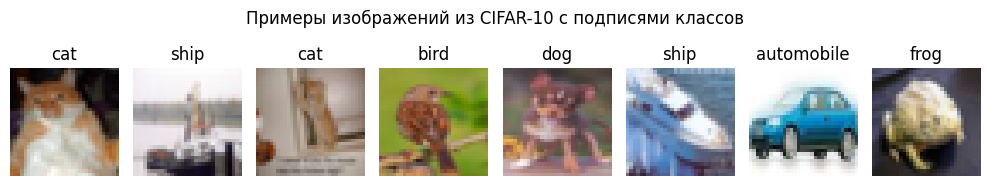

In [19]:
def imshow(img):
    # денормализация, т.к. мы использовали (0.5, 0.5, 0.5)
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

sample_loader = DataLoader(train_dataset_no_aug, batch_size=8, shuffle=True)
images, labels = next(iter(sample_loader))

plt.figure(figsize=(10, 2))
for idx in range(8):
    plt.subplot(1, 8, idx + 1)
    imshow(images[idx])
    plt.title(classes[labels[idx]])
    plt.axis('off')
plt.suptitle("Примеры изображений из CIFAR-10 с подписями классов")
plt.tight_layout()
plt.show()


# 5. DataLoader'ы и гиперпараметры


In [20]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10  # по заданию

train_loader_no_aug = DataLoader(train_dataset_no_aug, batch_size=batch_size,
                                 shuffle=True, num_workers=2)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size,
                              shuffle=True, num_workers=2)

val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size,
                         shuffle=False, num_workers=2)

# 6. Модель ResNet-18


In [21]:
def make_resnet18(num_classes=10, pretrained=True):
    if pretrained:
        model = resnet18(weights="IMAGENET1K_V1")
    else:
        model = resnet18(weights=None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)

criterion = nn.CrossEntropyLoss()

# 7. Функции обучения и тестирования


In [22]:
def train_step(model, dataloader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(dataloader, desc=f'Train Epoch {epoch}'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)

    return epoch_loss, epoch_acc


def val_step(model, dataloader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f'Val Epoch {epoch}'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)

    return epoch_loss, epoch_acc


def train_loop(
    model,
    start_epoch,
    end_epoch,
    optimizer,
    device,
    criterion,
    train_summary_writer,
    val_summary_writer,
    train_dataloader,
    val_dataloader,
    model_save_dir,
    best_acc=0.0,
    scheduler=None
):
    current_best_acc = best_acc

    for epoch in range(start_epoch, end_epoch):
        start_time = time.time()

        # --- train ---
        train_loss, train_accuracy = train_step(
            model, train_dataloader, optimizer, criterion, device, epoch
        )
        train_summary_writer.add_scalar('loss/train', train_loss, epoch)
        train_summary_writer.add_scalar('accuracy/train', train_accuracy, epoch)

        # --- validation ---
        val_loss, val_accuracy = val_step(
            model, val_dataloader, criterion, device, epoch
        )
        val_summary_writer.add_scalar('loss/val', val_loss, epoch)
        val_summary_writer.add_scalar('accuracy/val', val_accuracy, epoch)

        train_summary_writer.flush()
        val_summary_writer.flush()

        if scheduler is not None:
            scheduler.step(val_loss)

        # сохранение лучшей модели
        if val_accuracy > current_best_acc:
            current_best_acc = val_accuracy
            torch.save(
                {
                    'accuracy': val_accuracy,
                    'loss': val_loss,
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                },
                model_save_dir / 'best_model.pt'
            )
            print(f"[Epoch {epoch}] New best model saved with val_acc = {val_accuracy:.4f}")

        # сохранение последней модели
        torch.save(
            {
                'accuracy': val_accuracy,
                'loss': val_loss,
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            },
            model_save_dir / 'latest_model.pt'
        )

        epoch_time = time.time() - start_time
        print(f"[Epoch {epoch}] Time: {epoch_time:.2f}s | "
              f"Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")


def test_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Test Model'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = (all_preds == all_labels).mean()

    print(f"Test accuracy = {accuracy:.4f}")
    return all_preds, all_labels, accuracy

# 8. Обучение модели БЕЗ аугментации


In [23]:
model_no_aug = make_resnet18(num_classes=10, pretrained=True)
optimizer_no_aug = optim.Adam(model_no_aug.parameters(), lr=learning_rate)

log_dir_no_aug = logs_root / "cifar10_resnet18_no_aug"
log_dir_no_aug.mkdir(parents=True, exist_ok=True)

train_writer_no_aug = SummaryWriter(str(log_dir_no_aug / 'train'))
val_writer_no_aug   = SummaryWriter(str(log_dir_no_aug / 'val'))

save_dir_no_aug = checkpoints_root / "no_aug"
save_dir_no_aug.mkdir(parents=True, exist_ok=True)

train_loop(
    model=model_no_aug,
    start_epoch=0,
    end_epoch=num_epochs,
    optimizer=optimizer_no_aug,
    device=device,
    criterion=criterion,
    train_summary_writer=train_writer_no_aug,
    val_summary_writer=val_writer_no_aug,
    train_dataloader=train_loader_no_aug,  # БЕЗ аугментации
    val_dataloader=val_loader,
    model_save_dir=save_dir_no_aug,
    best_acc=0.0,
    scheduler=None
)

Val Epoch 0: 100%|██████████| 157/157 [00:33<00:00,  4.65it/s]


[Epoch 0] New best model saved with val_acc = 0.7216
[Epoch 0] Time: 196.34s | Train Acc: 0.6564 | Val Acc: 0.7216


Val Epoch 1: 100%|██████████| 157/157 [00:34<00:00,  4.54it/s]


[Epoch 1] New best model saved with val_acc = 0.7685
[Epoch 1] Time: 201.45s | Train Acc: 0.7661 | Val Acc: 0.7685


Val Epoch 2: 100%|██████████| 157/157 [00:34<00:00,  4.50it/s]


[Epoch 2] New best model saved with val_acc = 0.7903
[Epoch 2] Time: 204.54s | Train Acc: 0.8149 | Val Acc: 0.7903


Val Epoch 3: 100%|██████████| 157/157 [00:34<00:00,  4.57it/s]


[Epoch 3] New best model saved with val_acc = 0.7919
[Epoch 3] Time: 205.44s | Train Acc: 0.8501 | Val Acc: 0.7919


Val Epoch 4: 100%|██████████| 157/157 [00:33<00:00,  4.63it/s]


[Epoch 4] New best model saved with val_acc = 0.8047
[Epoch 4] Time: 198.39s | Train Acc: 0.8735 | Val Acc: 0.8047


Val Epoch 5: 100%|██████████| 157/157 [00:34<00:00,  4.55it/s]


[Epoch 5] Time: 199.76s | Train Acc: 0.9037 | Val Acc: 0.8016


Val Epoch 6: 100%|██████████| 157/157 [00:35<00:00,  4.42it/s]


[Epoch 6] Time: 213.54s | Train Acc: 0.9253 | Val Acc: 0.8017


Val Epoch 7: 100%|██████████| 157/157 [00:36<00:00,  4.36it/s]


[Epoch 7] New best model saved with val_acc = 0.8065
[Epoch 7] Time: 211.81s | Train Acc: 0.9347 | Val Acc: 0.8065


Val Epoch 8: 100%|██████████| 157/157 [00:35<00:00,  4.39it/s]


[Epoch 8] Time: 210.70s | Train Acc: 0.9496 | Val Acc: 0.7979


Val Epoch 9: 100%|██████████| 157/157 [00:36<00:00,  4.35it/s]

[Epoch 9] New best model saved with val_acc = 0.8096
[Epoch 9] Time: 211.20s | Train Acc: 0.9570 | Val Acc: 0.8096


# 9. Обучение модели С аугментацией


In [24]:
model_aug = make_resnet18(num_classes=10, pretrained=True)
optimizer_aug = optim.Adam(model_aug.parameters(), lr=learning_rate)

log_dir_aug = logs_root / "cifar10_resnet18_aug"
log_dir_aug.mkdir(parents=True, exist_ok=True)

train_writer_aug = SummaryWriter(str(log_dir_aug / 'train'))
val_writer_aug   = SummaryWriter(str(log_dir_aug / 'val'))

save_dir_aug = checkpoints_root / "aug"
save_dir_aug.mkdir(parents=True, exist_ok=True)

train_loop(
    model=model_aug,
    start_epoch=0,
    end_epoch=num_epochs,
    optimizer=optimizer_aug,
    device=device,
    criterion=criterion,
    train_summary_writer=train_writer_aug,
    val_summary_writer=val_writer_aug,
    train_dataloader=train_loader_aug,  # С аугментацией
    val_dataloader=val_loader,
    model_save_dir=save_dir_aug,
    best_acc=0.0,
    scheduler=None
)

Val Epoch 0: 100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


[Epoch 0] New best model saved with val_acc = 0.6976
[Epoch 0] Time: 209.01s | Train Acc: 0.6006 | Val Acc: 0.6976


Val Epoch 1: 100%|██████████| 157/157 [00:35<00:00,  4.36it/s]


[Epoch 1] New best model saved with val_acc = 0.7251
[Epoch 1] Time: 215.19s | Train Acc: 0.7098 | Val Acc: 0.7251


Val Epoch 2: 100%|██████████| 157/157 [00:36<00:00,  4.26it/s]


[Epoch 2] New best model saved with val_acc = 0.7683
[Epoch 2] Time: 219.25s | Train Acc: 0.7419 | Val Acc: 0.7683


Val Epoch 3: 100%|██████████| 157/157 [00:36<00:00,  4.34it/s]


[Epoch 3] New best model saved with val_acc = 0.7789
[Epoch 3] Time: 217.05s | Train Acc: 0.7616 | Val Acc: 0.7789


Val Epoch 4: 100%|██████████| 157/157 [00:36<00:00,  4.34it/s]


[Epoch 4] Time: 216.20s | Train Acc: 0.7810 | Val Acc: 0.7749


Val Epoch 5: 100%|██████████| 157/157 [00:36<00:00,  4.31it/s]


[Epoch 5] Time: 216.59s | Train Acc: 0.7844 | Val Acc: 0.7586


Val Epoch 6: 100%|██████████| 157/157 [00:36<00:00,  4.27it/s]


[Epoch 6] New best model saved with val_acc = 0.8016
[Epoch 6] Time: 220.00s | Train Acc: 0.7991 | Val Acc: 0.8016


Val Epoch 7: 100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


[Epoch 7] Time: 220.22s | Train Acc: 0.8074 | Val Acc: 0.7659


Val Epoch 8: 100%|██████████| 157/157 [00:36<00:00,  4.32it/s]


[Epoch 8] New best model saved with val_acc = 0.8161
[Epoch 8] Time: 218.80s | Train Acc: 0.8143 | Val Acc: 0.8161


Val Epoch 9: 100%|██████████| 157/157 [00:36<00:00,  4.28it/s]

[Epoch 9] New best model saved with val_acc = 0.8223
[Epoch 9] Time: 218.93s | Train Acc: 0.8208 | Val Acc: 0.8223


# 10. Тестирование обеих моделей


In [25]:
# модель без аугментации
checkpoint_no_aug = torch.load(save_dir_no_aug / 'best_model.pt', map_location=device)
model_no_aug.load_state_dict(checkpoint_no_aug['model_state_dict'])

all_preds_no_aug, all_labels_no_aug, test_acc_no_aug = test_model(model_no_aug, test_loader, device)
print(f"Test accuracy (NO AUG) = {test_acc_no_aug:.4f}")

# модель с аугментацией
checkpoint_aug = torch.load(save_dir_aug / 'best_model.pt', map_location=device)
model_aug.load_state_dict(checkpoint_aug['model_state_dict'])

all_preds_aug, all_labels_aug, test_acc_aug = test_model(model_aug, test_loader, device)
print(f"Test accuracy (AUG)    = {test_acc_aug:.4f}")

Test Model: 100%|██████████| 157/157 [00:32<00:00,  4.81it/s]


Test accuracy = 0.8044
Test accuracy (NO AUG) = 0.8044


Test Model: 100%|██████████| 157/157 [00:32<00:00,  4.79it/s]

Test accuracy = 0.8180
Test accuracy (AUG)    = 0.8180


# 11. Матрица ошибок для модели с аугментацией


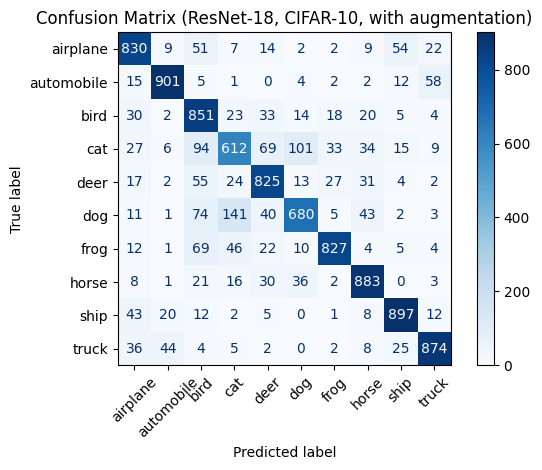

In [26]:
cm = confusion_matrix(all_labels_aug, all_preds_aug)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (ResNet-18, CIFAR-10, with augmentation)")
plt.tight_layout()
plt.show()